In [1]:
import numpy as np
from numpy.fft import rfft,irfft
import matplotlib.pyplot as plt

import pfb
import conjugate_gradient as cg

from datetime import datetime as dt
import pickle
import time

So as not to overcomplicate life just yet, this notebook will only compare Wiener with no Wiener, we'll leave the CG optimization to the next notebook. We're also only doing 4bit quantization here. 

In [15]:
# Constants
N_EPOCHS       = 16
LEN_EPOCH      = 1<<26 # 1<<26  # 1<<28 samples ~1.07 second's worth of data at 250 MSPS
DELTA_4BIT     = 0.353  # Optimal delta for 15-level quantization
NFRAME         = 2048   # 1<<11
NTAP           = 4      # 1<<2
UPCHAN_FACTOR  = 32     # 1<<5, higher frequency resolution for upchannelization
TD_NOISE_SIGMA = 10     # Amount of noise added to time-domain signal
PRNG_SEED      = 1747 #4 # 42#133599340
WIENER_THRESH  = 0.1
DROP_NROWS     = 4 # 10 # Number of up-channelized rows to drop to make sure we don't count the transient; make this number even

CONSTS = {
    "N_EPOCHS":N_EPOCHS,
    "LEN_EPOCH":LEN_EPOCH,
    "DELTA_4BIT":DELTA_4BIT,
    "NFRAME":NFRAME,
    "NTAP":NTAP,
    "UPCHAN_FACTOR":UPCHAN_FACTOR,
    "TD_NOISE_SIGMA":TD_NOISE_SIGMA,
    "PRNG_SEED":PRNG_SEED,
    "WIENER_THRESH":WIENER_THRESH,
    "DROP_NROWS":DROP_NROWS
}

print("Number of up-channelized rows you'll get:", (1<<int(.5+np.log2(LEN_EPOCH) - np.log2(NFRAME*UPCHAN_FACTOR))) - NTAP+1 - DROP_NROWS)

Number of up-channelized rows you'll get: 1017


In [16]:
def get_rfft_spec(sig, nframe):
    spec = np.reshape(sig, (len(sig)//nframe,nframe))
    return rfft(spec, axis=1)

def rechannelize(sig, quantize=False, usepfb=True, isupchan=False, 
                upchan_factor=4, wiener_thresh=0.0, drop_nrows=0, 
                only_upchan=False):
    """Channelize and optionally quantize and/or up-channelize a signal. 
    
    Uses global constants (only capitalized variables). 
    
    Parameters
    ----------
    sig : np.ndarray
        1d numpy real, time-domain signal
    quantize : bool
        If true, quantize the signal to four bits real + four bits imaginary once channelized
    usepfb : bool
        If True, channelize with a PFB. If False, channelize with STFTs. 
    isupchan : bool
        If True, up-channelize the signal by a factor of upchan_factor
    upchan_factor : int
        If upchan is True, the signal will be upchannelized by a factor of 
        If it's not a power of two this method might break. Just make it a power of two. 
    wiener_thresh : float
        Wiener threshold. Set to 0 for no Wiener filtering. This is only relevant if 
        upchan is True. 
    only_upchan : bool
        If this is True, only apply the higher-frequency channelization. Over-rides 
        quantization and inverse.

    returns
    -------
    snr : np.ndarray
        Signal to noise ratio in each channel, in dB
    """
    if usepfb is True:
        channelize = lambda x: pfb.forward_pfb(x, nchan=NFRAME//2+1, ntap=NTAP)
        upchan     = lambda x: pfb.forward_pfb(x, nchan=(NFRAME * upchan_factor)//2+1, ntap=NTAP)
        inverse    = lambda x: pfb.inverse_pfb(x, nchan=NFRAME//2+1, ntap=NTAP, 
                                               wiener_thresh=wiener_thresh)
    else:
        channelize = lambda x: get_rfft_spec(x, NFRAME)
        upchan     = lambda x: get_rfft_spec(x, NFRAME * upchan_factor)
        inverse    = lambda x: irfft(x, axis=1).flatten()
    if only_upchan is True:
        spec = upchan(sig)
    else:
        spec = channelize(sig)
        if quantize is True:
            std_spec = (np.std(np.real(spec)) + np.std(np.imag(spec)))/2 # for normalization
            spec = pfb.quantize_8_bit(spec, delta=std_spec * DELTA_4BIT)
        if isupchan is True:
            spec = upchan(np.real(inverse(spec)))
    if DROP_NROWS//2 > 0:
        spec = spec[DROP_NROWS//2:-DROP_NROWS//2,:]
    return spec

def get_snr_corr(sig1, sig2, verbose_plot=False, **kwargs):
    """Estimate the Signal to Noise Ratio in each channel by correlating sig1 with sig2.
    
    Uses global constants (only capitalized variables). 

    Parameters
    ----------
    sig1 : np.ndarray
        1d numpy real, time-domain signal with noise, to be correlated with sig2
    sig2 : np.ndarray
        1d numpy real, time-domain signal with noise, to be correlated with sig1
    verbose_plot : bool
        Defaults to False. If True, plot stuff. 
    **kwargs : dict
        Arguments passed to rechannelize()

    returns
    -------
    snr : np.ndarray
        Signal to noise ratio in each channel, in dB
    """
    spec1 = rechannelize(sig1, **kwargs)
    spec2 = rechannelize(sig2, **kwargs)
    corr = (spec1 * np.conj(spec2)).mean(axis=0)
    autocorr1 = (abs(spec1)**2).mean(axis=0)
    autocorr2 = (abs(spec2)**2).mean(axis=0)
    s = np.real(corr)             # Signal
    n = autocorr1 - np.real(corr) # Noise
    n2= autocorr2 - np.real(corr)
    # print("s",s)
    # print("n",n)
    snr = 10 * np.log10(s/n)      # Signal to Noise Ratio
    info_string = "{}{}{}{}\nSNR = {:.2f}".format("PFB" if kwargs.get("usepfb",False) else "FFT",
        ", quantized" if kwargs.get("quantize",False) else "",
        f", upchannelized by {kwargs.get('upchan_factor','<default>')}" if kwargs.get("isupchan",False) else "",
        f", Wienered at {kwargs.get('wiener_thresh',False)}" if kwargs.get("wiener_thresh",False) else "",
        snr.mean())
    if verbose_plot is True:
        plt.figure(figsize=(6,2))
        plt.title(info_string,fontsize=9)
        plt.plot(s,label="signal")
        plt.plot(n,label=f"noise min={min(n)}")
        plt.plot(n2,label=f"n2 min={min(n2)}")
        # print(f"noise mean = {n.mean()}, std = {n.std()}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(info_string)
    return snr

### Bench

In [17]:
# Make Sig
signal = np.random.randn(LEN_EPOCH // 8)
%timeit signal = np.random.randn(LEN_EPOCH // 8)

# Forward PFB (x2)
spec = pfb.forward_pfb(signal, nchan=NFRAME//2+1, ntap=NTAP)
%timeit pfb.forward_pfb(signal, nchan=NFRAME//2+1, ntap=NTAP)

# Inverse PFB (x1)
%timeit pfb.inverse_pfb(spec, nchan=NFRAME//2+1, ntap=NTAP, wiener_thresh=0.1)

# Quantize (x1)
std_spec = (np.std(np.real(spec)) + np.std(np.imag(spec)))/2 # for normalization
spec_q = pfb.quantize_8_bit(spec, delta=std_spec * DELTA_4BIT)
%timeit pfb.quantize_8_bit(spec, delta=std_spec * DELTA_4BIT)

156 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
158 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
698 ms ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
160 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
# # Generate two timestreams, same underlying signal, different realizations
# signal = np.random.randn(LEN_EPOCH * N_EPOCHS)
# sig1 = signal + np.random.randn(LEN_EPOCH * N_EPOCHS) * TD_NOISE_SIGMA
# sig2 = signal + np.random.randn(LEN_EPOCH * N_EPOCHS) * TD_NOISE_SIGMA

### FFT SNR analysis

Without Quantization noise

In [6]:
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=False, isupchan=False).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=False, isupchan=False).mean()
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=True, isupchan=False).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=True, isupchan=False).mean()

# print()
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=False, isupchan=True, wiener_thresh=0.0).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=False, isupchan=True, wiener_thresh=0.0).mean()
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=True, isupchan=True, wiener_thresh=0.0).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=True, isupchan=True, upchan_factor=32, wiener_thresh=0.0).mean()

# print()
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=False, isupchan=True, wiener_thresh=0.1).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=False, isupchan=True, wiener_thresh=0.1).mean()
# snr = get_snr_corr(sig1, sig2, quantize=False, usepfb=True, isupchan=True, wiener_thresh=0.1).mean()
# snr = get_snr_corr(sig1, sig2, quantize=True, usepfb=True, isupchan=True, upchan_factor=32, wiener_thresh=0.1).mean()


In [7]:
input("Are you sure? [Enter]")

time_total_start = time.time()

kwargs_wien = {"quantize":True, "usepfb":True, "isupchan":True, "upchan_factor":UPCHAN_FACTOR, "wiener_thresh":0.1}
kwargs_nofilt = {"quantize":True, "usepfb":True, "isupchan":True, "upchan_factor":UPCHAN_FACTOR, "wiener_thresh":0.0}
kwargs_upchan_time_domain_sig = {"usepfb":True, "upchan_factor":UPCHAN_FACTOR, "only_upchan":True}

corrmean_wien   = []
corrmean_nofilt = []
corrmean_fp     = []
corrmean_1perc  = []
corrmean_3perc  = []
corrmean_5perc  = []
corrmean_10perc = []
prng = np.random.Generator(np.random.PCG64(seed=PRNG_SEED))
for epoch in range(N_EPOCHS):
    timeA = time.time()
    # Make a pseudo-random signal
    print("Generating signal...", end=" ")
    signal = prng.normal(0,1,LEN_EPOCH)
    sig1 = signal + prng.normal(0,TD_NOISE_SIGMA,LEN_EPOCH) 
    sig2 = signal + prng.normal(0,TD_NOISE_SIGMA,LEN_EPOCH) 
    timeB = time.time()
    print(f"took {timeB-timeA:.3f} seconds")

    
    # Infinite precision
    spec1=rechannelize(sig1,**kwargs_upchan_time_domain_sig) # Just channelize original signal 
    spec2=rechannelize(sig2,**kwargs_upchan_time_domain_sig) # directly to higher resolution
    corrmean_fp.append(np.mean(spec1 * np.conj(spec2)))
    timeC = time.time()
    print(f"{epoch+1}/{N_EPOCHS} mean power FP precision {np.real(corrmean_fp[-1]):.1f}\t({timeC-timeB:.1f} s)")
    
    # Wiener filtered
    spec1=rechannelize(sig1,**kwargs_wien)
    spec2=rechannelize(sig2,**kwargs_wien)
    corrmean_wien.append(np.mean(spec1 * np.conj(spec2)))
    timeD = time.time()
    print(f"{epoch+1}/{N_EPOCHS} mean power wiener filtered {np.real(corrmean_wien[-1]):.1f}\t({timeD-timeC:.1f} s)")
    
    # No filter
    spec1=rechannelize(sig1,**kwargs_nofilt)
    spec2=rechannelize(sig2,**kwargs_nofilt)
    corrmean_nofilt.append(np.mean(spec1 * np.conj(spec2)))
    timeE = time.time()
    print(f"{epoch+1}/{N_EPOCHS} mean power no filter {np.real(corrmean_nofilt[-1]):.1f}\t({timeE-timeD:.1f} s)")
    
    # Optimize with CG
    conj_kwargs = {
        "frac_prior":0.01, 
        "delta":DELTA_4BIT, 
        "k":LEN_EPOCH//NFRAME, 
        "lblock":NFRAME, 
        "verbose":False, 
        "wiener_thresh":WIENER_THRESH,
        "npersave":7
    }
    # _, _, sig1_10, sig1_x5, sig1_x3, sig1_x1 = cg.conj_grad_one_three_five_perc(
    #     x=sig1,
    #     delta=0.343,          # quantization delta in stds
    #     k=LEN_EPOCH//NFRAME,     
    #     lblock=NFRAME,
    #     verbose=False,         # True for plots
    #     wiener_thresh=0.1, npersave1=7, npersave3=5, npersave5=4, npersave10=3
    # )
    # _, _, sig2_10, sig2_x5, sig2_x3, sig2_x1 = cg.conj_grad_one_three_five_perc(
    #     x=sig2,
    #     delta=0.343,          # quantization delta in stds
    #     k=LEN_EPOCH//NFRAME,     
    #     lblock=NFRAME,
    #     verbose=False,         # True for plots
    #     wiener_thresh=0.1, npersave1=7, npersave3=5, npersave5=4, npersave10=3
    # )
    for corrmean_list,frac_prior,npersave in zip((corrmean_1perc, corrmean_3perc, corrmean_5perc, corrmean_10perc),(0.01, 0.03, 0.05, 0.1), (7, 5, 4, 3)):
        timeF = time.time()
        conj_kwargs["frac_prior"] = frac_prior
        conj_kwargs["npersave"]   = npersave
        _, sig1_10 = cg.conj_grad_with_prior(x=sig1,**conj_kwargs)
        _, sig2_10 = cg.conj_grad_with_prior(x=sig2,**conj_kwargs)
        spec1=rechannelize(sig1_10,**kwargs_upchan_time_domain_sig)
        spec2=rechannelize(sig2_10,**kwargs_upchan_time_domain_sig)
        corrmean_list.append(np.mean(spec1 * np.conj(spec2)))
        timeG = time.time()
        print(f"{epoch+1}/{N_EPOCHS} mean power CG {int(0.5+100*frac_prior)}% {np.real(corrmean_list[-1]):.1f}\t({timeG-timeF:.1f} s)")


time_total_end = time.time()
time_total_elapsed = time_total_end - time_total_start
print(f"\nDone!\nTotal time elapsed: {int(time_total_elapsed/3600)} hours {int((time_total_elapsed%3600)/60)} minutes {time_total_elapsed%60:.3f} seconds")

Are you sure? [Enter] 


Generating signal... took 2.619 seconds
1/128 mean power FP precision 53245.9	(4.3 s)
1/128 mean power wiener filtered 50894.8	(22.1 s)
1/128 mean power no filter 45714.9	(21.6 s)
1/128 mean power CG 1% 49060.3	(121.0 s)
1/128 mean power CG 3% 49244.7	(188.0 s)
1/128 mean power CG 5% 49364.9	(246.0 s)
1/128 mean power CG 10% 49527.1	(287.3 s)
Generating signal... took 2.767 seconds
2/128 mean power FP precision 53298.2	(4.6 s)
2/128 mean power wiener filtered 50750.7	(19.4 s)
2/128 mean power no filter 47103.4	(18.8 s)
2/128 mean power CG 1% 48997.3	(111.2 s)
2/128 mean power CG 3% 49163.2	(180.7 s)
2/128 mean power CG 5% 49264.4	(247.3 s)
2/128 mean power CG 10% 49334.9	(287.1 s)
Generating signal... took 2.692 seconds
3/128 mean power FP precision 52020.7	(4.5 s)
3/128 mean power wiener filtered 49717.5	(19.2 s)
3/128 mean power no filter 52271.1	(19.0 s)
3/128 mean power CG 1% 47982.8	(113.5 s)
3/128 mean power CG 3% 48078.4	(180.0 s)
3/128 mean power CG 5% 48251.6	(247.0 s)
3/128 m

KeyboardInterrupt: 

In [ ]:
dumpdict = {}
for method,corrmean,kwargs in zip(
    ("wien","nofilt","fp","cg_1perc","cg_3perc","cg_5perc","cg_10perc"), 
    (corrmean_wien, corrmean_nofilt, corrmean_fp, corrmean_1perc, corrmean_3perc, corrmean_5perc, corrmean_10perc), 
    (kwargs_wien, kwargs_nofilt, kwargs_upchan_time_domain_sig, kwargs_upchan_time_domain_sig, kwargs_upchan_time_domain_sig, kwargs_upchan_time_domain_sig, kwargs_upchan_time_domain_sig)):
    dumpdict[method] = {"kwargs": kwargs, "CONSTS": CONSTS, "corrmean": corrmean}
now = dt.now()
with open(f'{now}_snr_measurement.pkl','wb') as f:
    pickle.dump(dumpdict, f)

In [18]:
with open(f'seed_22_nepoch_2_2024-11-21 14:24:37.627006_snr_measurement.pkl','rb') as f:
    dumpdict1 = pickle.load(f)

with open(f'seed_22_nepoch_2_2024-11-21 14:26:46.030753_snr_measurement.pkl','rb') as f:
    dumpdict2 = pickle.load(f)


wien
----
Sample mean             : 4.98e+04 ± 1.01e+02 	(0.203%)
Sample STD              : 8.07e+02 ± 7.13e+01 	(8.84%)
SNR (sqrt x^2/std^2)    : 6.17e+01 ± 5.46e+00 	(8.84%)
SNR ratios 		: 98.35% ± 12.30

nofilt
------
Sample mean             : 5.08e+04 ± 9.15e+02 	(1.801%)
Sample STD              : 7.32e+03 ± 6.47e+02 	(8.84%)
SNR (sqrt x^2/std^2)    : 6.94e+00 ± 6.26e-01 	(9.02%)
SNR ratios 		: 11.06% ± 1.40

fp
--
Sample mean             : 5.21e+04 ± 1.04e+02 	(0.199%)
Sample STD              : 8.31e+02 ± 7.34e+01 	(8.84%)
SNR (sqrt x^2/std^2)    : 6.27e+01 ± 5.55e+00 	(8.84%)
SNR ratios 		: 100.00% ± 12.50

cg_1perc
--------
Sample mean             : 4.80e+04 ± 9.71e+01 	(0.202%)
Sample STD              : 7.77e+02 ± 6.86e+01 	(8.84%)
SNR (sqrt x^2/std^2)    : 6.18e+01 ± 5.47e+00 	(8.84%)
SNR ratios 		: 98.55% ± 12.32

cg_3perc
--------
Sample mean             : 4.82e+04 ± 9.73e+01 	(0.202%)
Sample STD              : 7.78e+02 ± 6.88e+01 	(8.84%)
SNR (sqrt x^2/std^2)    : 6.19e+01

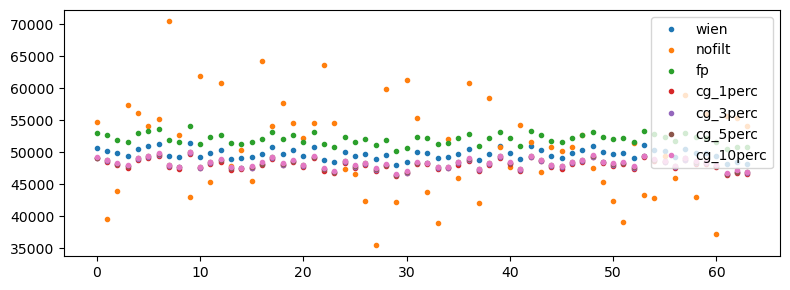

In [14]:
def get_and_print_stats(method,data,compare_snr=None,isplot=True):
    sample_mean = data.mean()
    sample_std = np.sqrt( np.sum((sample_mean - data)**2) / (len(data)-1) )
    SE_mean = sample_std / np.sqrt(len(data))
    SE_std = sample_std / np.sqrt(2 * len(data))
    snr = np.sqrt(sample_mean**2)/np.sqrt(sample_std**2)
    snr_err = snr * np.sqrt((SE_mean/sample_mean)**2 + (SE_std/sample_std)**2) # assumes delta mu / mu and delta sig / sig are small
    if isplot is True:
        plt.plot(data,'.',label=method)
        print(f"\
Sample mean             : {np.real(sample_mean):.2e} ± {SE_mean:.2e} \t({100*SE_mean/sample_mean:.3f}%)\n\
Sample STD              : {sample_std:.2e} ± {SE_std:.2e} \t({100*SE_std/sample_std:.2f}%)\n\
SNR (sqrt x^2/std^2)    : {snr:.2e} ± {snr_err:.2e} \t({100*snr_err/snr:.2f}%)")
    if compare_snr is not None:
        snr0,snr0err = compare_snr[0],compare_snr[1]
        snr_ratios_err = np.sqrt((snr/snr0)**2*(snr0err/snr0)**2 + (snr_err/snr0)**2)
        print(f"SNR ratios \t\t: {snr/compare_snr[0]*100:.2f}% ± {snr_ratios_err*100:.2f}")
    return snr, snr_err

def print_data(dumpdict):
    fp_snr,fp_snr_err = get_and_print_stats("fp", np.real(dumpdict['fp']['corrmean']), isplot=False)
    plt.figure(figsize=(8,3))
    for method,datadict in dumpdict.items():
        print("\n"+method)
        print("-"*len(method))
        get_and_print_stats(method,np.real(datadict['corrmean']),compare_snr=(fp_snr,fp_snr_err))
    plt.legend()
    plt.tight_layout()
    plt.show()

dumpdict=dumpdict0
print_data(dumpdict)
# corrmean_wien = dumpdict['wien']['corrmean']
# corrmean_wien = np.real(corrmean_wien)
# plt.plot(corrmean_wien)

In [39]:
dumpdict0['wien'].keys()

dict_keys(['kwargs', 'CONSTS', 'corrmean'])

In [61]:
# fuse dump dicts
def fuse_dump_dicts(dumpdict0, dumpdict1):
    dd={}
    for i,j in zip(dumpdict0.items(), dumpdict1.items()):
        #print(i[0], i[1].keys())
        # check that kwargs and consts are same
        assert i[0]==j[0]
        key = i[0]
        assert i[1]['kwargs']==j[1]['kwargs'], "Error, kwargs different, cannot merge"
        kwargs = i[1]['kwargs']
        assert i[1]['CONSTS']['LEN_EPOCH']==j[1]['CONSTS']['LEN_EPOCH'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['DELTA_4BIT']==j[1]['CONSTS']['DELTA_4BIT'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['NFRAME']==j[1]['CONSTS']['NFRAME'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['NTAP']==j[1]['CONSTS']['NTAP'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['UPCHAN_FACTOR']==j[1]['CONSTS']['UPCHAN_FACTOR'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['DROP_NROWS']==j[1]['CONSTS']['DROP_NROWS'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['WIENER_THRESH']==j[1]['CONSTS']['WIENER_THRESH'], "Error, key CONSTS differ, cannot merge"
        assert i[1]['CONSTS']['TD_NOISE_SIGMA']==j[1]['CONSTS']['TD_NOISE_SIGMA'], "Error, key CONSTS differ, cannot merge"
        consts = i[1]['CONSTS']
        dd[key] = {'kwargs':kwargs, 'CONSTS':consts, 'corrmean':i[1]['corrmean'] + j[1]['corrmean']}
    return dd

dd = fuse_dump_dicts(dumpdict0, dumpdict1)
dd = fuse_dump_dicts(dd, dumpdict2)
dd = fuse_dump_dicts(dd, dumpdict3)
dd = fuse_dump_dicts(dd, dumpdict4)

print_data(dd)

AssertionError: Error, kwargs different, cannot merge

In [ ]:
x=50982.51
dx=1495.314
std=51626.24
stderr=1057.347
f"{x**2:.2e} , {2*x*dx:.2e} , {dx**2:.2e}, {x**2/std**2:.2e}"

In [ ]:
with open(f'2024-09-16 08:51:29.277051 snr_measurement.pkl','rb') as f:
    kwargs = pickle.load(f)
    consts = pickle.load(f)
    data   = pickle.load(f)

data = np.asarray(data)
# plt.plot(np.real(arr))
# plt.plot(np.imag(arr))
sample_mean = data.mean()
sample_std = np.sqrt(sum(abs(data - sample_mean)**2) / (consts['N_EPOCHS'] - 1))
SE_mean = sample_std / np.sqrt(consts['N_EPOCHS']) # standard error in the mean
SE_std = sample_std / np.sqrt(2 * (consts['N_EPOCHS'] - 1))

sample_mean, sample_std, SE_mean, SE_std

print(f"Sample mean            : {np.real(sample_mean):.2f}\n\
Sample STD             : {sample_std:.2f}\n\
Standard Error in mean : {SE_mean:.3f}\n\
Standard Error in STD  : {SE_std:.3f}")

In [ ]:
consts

In [ ]:
powers = np.array(powers)
n = len(powers)
sample_mean = np.mean(powers)
sample_stdev = np.sqrt(np.sum(abs(powers-sample_mean)**2) / (n-1))
err_in_mean = sample_stdev / np.sqrt(n)

print(f"stdev = {sample_stdev:.1f}\nmean = {np.real(sample_mean):.1f}\nmean err = {err_in_mean:.3f}")


In [ ]:
powers = np.array(powers)
n = len(powers)
sample_mean = np.mean(powers)
sample_stdev = np.sqrt(np.sum(abs(powers-sample_mean)**2) / (n-1))
err_in_mean = sample_stdev / np.sqrt(n)

print(f"stdev = {sample_stdev:.1f}\nmean = {np.real(sample_mean):.1f}\nmean err = {err_in_mean:.3f}")


In [118]:
from datetime import datetime as dt
f"{dt.now()}"

'2024-09-13 12:03:34.542569'

In [115]:
import pickle
# serialize
with open("data.pkl",'wb') as f:
    pickle.dump(kwargs, f) 
    pickle.dump(powers, f)

In [116]:
with open('data.pkl','rb') as f:
    print(pickle.load(f))
    input("[Enter]")
    print(pickle.load(f))    

{'quantize': True, 'usepfb': True, 'isupchan': True, 'upchan_factor': 32, 'wiener_thresh': 0.0, 'drop_nrows': 10}


[Enter] 


[51468.60235381 +24.21375583j 51361.20546312 -39.13596832j
 51416.72414044 -45.03663199j 51352.89460731 +20.03624506j
 51242.15653027 +32.36121811j 51389.86389834  -0.14710532j
 51333.56650997 -31.21759395j 51354.89791771-118.7208946j
 51424.57108576 -29.71995028j 51309.50614489 -91.3380315j
 51319.40044988 +13.08615023j 51421.94023697 +22.49406926j
 51485.58761093  +2.35984471j 51447.7017655  -76.117301j
 51454.11078157 +48.85819259j 51402.25099721 -68.30456146j
 51371.74635442 +79.57525329j 51441.88104594 +56.74595166j
 51544.24140276 -53.24474712j 51461.87805746+115.91339168j
 51399.38980198 -48.7264323j  51363.11875782 +71.48814367j
 51350.44692356 +15.6335975j  51453.49667809  -3.89558099j
 51388.72557177 +24.10576404j 51507.71040142+103.27625128j
 51389.95539954  +2.61220181j 51401.28237326 +13.9535463j
 51354.85958408 +33.97144595j 51459.98978044 +94.73191225j
 51450.44949158 +89.94387067j 51474.20103056 -24.99666245j]


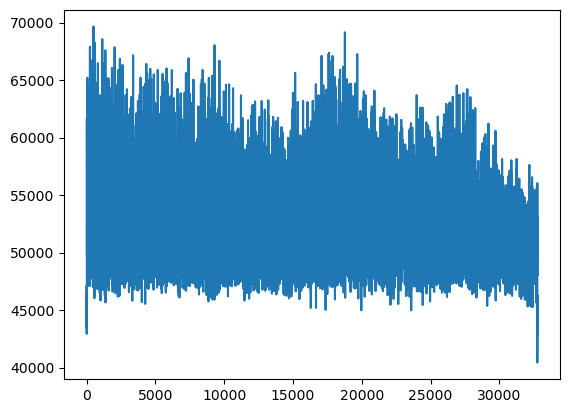

In [106]:
power = np.mean(corr,axis=0)
plt.plot(np.real(power))

In [96]:
spec1.shape

(1021, 32769)

In [98]:
np.log2(32768)

15.0

In [100]:
1<<(16-5)

2048

In [68]:
spec1 = get_rfft_spec(sig1, NFRAME)[:,1:] # don't care about DC
spec2 = get_rfft_spec(sig2, NFRAME)[:,1:]
corr = spec1 * np.conj(spec2)
# Average the corrlation over one-second (LEN_EPOCH in num samples) intervals
corr1s = corr.reshape((N_EPOCHS,LEN_EPOCH//2)).mean(axis=1)
assert corr1s.shape == (N_EPOCHS,) # sanity check
sig_1s_power_fft = np.real(corr1s.mean())
noise_1s_power_fft = corr1s.std()
snr_1s_fft = 10 * np.log10(sig_1s_power_fft / noise_1s_power_fft)
print(f"SNR between 1s correlations without quantization noise is {snr_1s_fft:.2f} dB")

SNR between 1s correlations without quantization noise is 30.77 dB


Add quantization noise, see affect on SNR

In [20]:
std_spec = np.std(np.concatenate([np.real(spec1),np.imag(spec1),np.real(spec2),np.imag(spec2)]))
spec1_quant = pfb.quantize_8_bit(spec1, delta = std_spec * DELTA_4BIT)
spec2_quant = pfb.quantize_8_bit(spec2, delta = std_spec * DELTA_4BIT)
corr = spec1_quant * np.conj(spec2_quant)
# Average the correlation over one-second intervals
corr1s = corr.reshape((N_EPOCHS,LEN_EPOCH//2)).mean(axis=1)
assert corr1s.shape == (N_EPOCHS,) # sanity check
sig_1s_power_quantized = np.real(corr1s.mean())
noise_1s_power_quantized = corr1s.std()
snr_1s_pfb = 10 * np.log10(sig_1s_power_pfb / noise_1s_power_pfb)
print(f"SNR between 1s correlations with quantization noise is {snr_1s_pfb:.2f} dB")

NameError: name 'sig_1s_power_pfb' is not defined

### PFB SNR analysis